First of al, we import all python libraries

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import matplotlib.image as mpimg
import astropy.units as u
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
import venn
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance as ssd
import warnings
import scipy.stats as stats

the next step is to define a class called HMXB with all methods for plots, catalogs and auxiliary functions.

In [ ]:
class HMXB:
    def __init__(self, name_excel="HMXB_catalogs.xlsx", name_excel_2="HMXB_cat.xlsx"):
        self.name_excel = name_excel
        self.name_excel_2 = name_excel_2
        self.load_catalogs()

    def load_catalogs(self):
        """
        Define all the catalogs: Neumann, Fortin, Kim, and Malacaria.
        Also, it loads all the names, counts, etc.
        """
        xls = pd.ExcelFile(self.name_excel)

        self.cat_neuman = xls.parse('HMXB_cat_Neumann')
        self.cat_fortin = xls.parse('v2023-09_Fortin')
        self.kim_transient = xls.parse('kim_transient')
        self.kim_persistent = xls.parse('kim_persistent')
        self.malacaria_persistent = xls.parse('malacaria_persistent')
        self.malacaria_transient = xls.parse('malacaria_transient')
        self.cat_neuman_2 = pd.read_excel(self.name_excel_2, sheet_name="HMXB_cat")


        names_neuman = self.cat_neuman["Name"]

        kim_t_column = self.kim_transient.iloc[302:367, 0]
        df_kim_t = kim_t_column.str.split(expand=True)
        names_kim_t = df_kim_t[1] + " " + df_kim_t[2]

        kim_p_column = self.kim_persistent.iloc[173:192, 0]
        df_kim_p = kim_p_column.str.split(expand=True)
        names_kim_p = df_kim_p[1] + " " + df_kim_p[2]

        names_malacaria_persistent = self.malacaria_persistent["Source"].iloc[1:].str.replace(r"\s*\(.*?\)", "", regex=True)
        names_malacaria_transient = self.malacaria_transient["Source"].iloc[1:].str.replace(r"\s*\(.*?\)", "", regex=True)

        names_fortin = self.cat_fortin["Main_ID"].str.replace(r"\s*\(.*?\)", "", regex=True)

        all_catalog_names = pd.concat([
            names_neuman,
            names_fortin,
            names_kim_t,
            names_kim_p,
            names_malacaria_persistent,
            names_malacaria_transient
        ])

        self.names_count = all_catalog_names.value_counts()
        
        self.period = self.cat_fortin["Period"].values
        self.spin_period = self.cat_fortin["Spin_period"].values
        self.classes = self.cat_fortin["Class"].values
        
        self.cat_neuman['Geometric_Mean'] = np.sqrt(self.cat_neuman['Max_Soft_Flux'] * self.cat_neuman['Min_Soft_Flux'])


    def normalize_name(self, name):
        """
        Normalize names: remove spaces and capital letters.
        """
        if isinstance(name, str):
            return ''.join(name.upper().split())
        return ''

    def Compare_Neumann_Fortin(self):
        """
        It displays the number and names of systems common between Fortin and Neumann catalogs
        , showing also their single or lonely systems (not common) to each of them.
        """
        self.cat_neuman['IDS_list'] = self.cat_neuman['IDS'].str.split(',').apply(
            lambda lst: [self.normalize_name(x) for x in lst if isinstance(x, str)]
        )

        for col in self.cat_neuman.columns:
            if 'ID' in col:
                for index, row in self.cat_neuman.iterrows():
                    value = row[col]
                    if isinstance(value, str) and pd.notnull(value):
                        normalized_value = self.normalize_name(value)
                        if normalized_value:
                            self.cat_neuman.at[index, 'IDS_list'].append(normalized_value)

        neuman_set = set()
        for _, row in self.cat_neuman.iterrows():
            neuman_set.add(self.normalize_name(row['Name']))
            neuman_set.update(row['IDS_list'])

        fortin_columns = [col for col in self.cat_fortin.columns if 'ID' in col or 'Name' in col]
        fortin_objects = []

        for index, row in self.cat_fortin.iterrows():
            fortin_names = set()
            rep = None
            for col in fortin_columns:
                value = row[col]
                if pd.notnull(value):
                    norm_val = self.normalize_name(value)
                    if norm_val:
                        fortin_names.add(norm_val)
                        if rep is None:
                            rep = value
            if fortin_names:
                fortin_objects.append((index, fortin_names, rep))

        fortin_set = set()
        for obj in fortin_objects:
            fortin_set.update(obj[1])

        common, only_neumann, only_fortin = [], [], []

        for _, row in self.cat_neuman.iterrows():
            object_names = set(row['IDS_list'])
            object_names.add(self.normalize_name(row['Name']))
            if object_names.intersection(fortin_set):
                common.append(row['Name'])
            else:
                only_neumann.append(row['Name'])

        for _, names_set, rep in fortin_objects:
            if not names_set.intersection(neuman_set):
                if rep is not None and pd.notnull(rep):
                    only_fortin.append(rep)

        self.common = [x for x in common if pd.notnull(x)]
        self.only_neumann = [x for x in only_neumann if pd.notnull(x)]
        self.only_fortin = [x for x in only_fortin if pd.notnull(x)]

        print("Common objects:", self.common)
        print("Number of common objects:", len(self.common))
        print("\nObjects only in cat_neuman:", self.only_neumann)
        print("Number of objects only in cat_neuman:", len(self.only_neumann))
        print("\nObjects only in cat_fortin:", self.only_fortin)
        print("Number of objects only in cat_fortin:", len(self.only_fortin))

    def Build_Final_Dataframe(self):
        """
        It Creates a dataframe with the interest' variables, i.e. all columns for 
        our study. Also, it renames some columns.
        """
        cols_f = ['Main_ID', 'Spectype', 'Mo', 'Period', 'Eccentricity', 'Spin_period', 'Distance', 'Class']
        cols_n = ['Name', 'SpType', 'Mean_Mass', 'Teff', 'N_H', 'Max_Soft_Flux', 'Min_Soft_Flux', 'Max_Hard_Flux', 'Min_Hard_Flux']

        fortin_filtered = self.cat_fortin[self.cat_fortin['Main_ID'].isin(self.common)][cols_f]
        neuman_filtered = self.cat_neuman[self.cat_neuman['Name'].isin(self.common)][cols_n]

        fortin_filtered = fortin_filtered.rename(columns={'Main_ID': 'Object'})
        neuman_filtered = neuman_filtered.rename(columns={'Name': 'Object'})

        final_dataframe = pd.merge(fortin_filtered, neuman_filtered, on='Object', how='outer')

        final_dataframe['Mean_Soft_Flux'] = np.sqrt(final_dataframe['Min_Soft_Flux'] * final_dataframe['Max_Soft_Flux'])
        final_dataframe['Mean_Hard_Flux'] = np.sqrt(final_dataframe['Min_Hard_Flux'] * final_dataframe['Max_Hard_Flux'])
        final_dataframe['Hardness'] = final_dataframe['Mean_Hard_Flux'] / final_dataframe['Mean_Soft_Flux']

        final_dataframe.rename(columns={
            "SpType": "SpType_Fortin", 
            "Spectype": "SpType_Neumann", 
            "Mean_Mass": "M_X", 
            "Mo": "M*"
        }, inplace=True)

        return final_dataframe

    def plot_class_distribution(self):
        """
        It plots the Distribution of classes in the fortin catalogue.
        """
        class_counts = self.cat_fortin['Class'].value_counts()
        top_classes = class_counts[:4]
        others_count = class_counts[4:].sum()
        aggregated_counts = pd.concat([top_classes, pd.Series({'Others': others_count})])

        plt.figure(figsize=(8, 8))
        plt.pie(
            aggregated_counts, 
            labels=aggregated_counts.index, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=plt.cm.tab10.colors[:len(aggregated_counts)]
        )
        plt.title('Fortin Distribution of Classes')
        plt.show()

    def plot_null_histogram(self, df, title):
        """
        It shows the null values for all columns in 
        the df dataframe
        """
        null_counts = df.isnull().sum()
        non_null_counts = df.notnull().sum()
        df_nulls = pd.DataFrame({
            'Nulls': null_counts,
            'Non-Nulls': non_null_counts
        })
        ax = df_nulls.plot(kind='bar', figsize=(10, 6), width=0.8)
        ax.set_title(f'Null and Non-Null Counts per Column: {title}')
        ax.set_ylabel('Count')
        ax.set_xlabel('Columns')
        plt.xticks(rotation=60, ha='right')
        plt.tight_layout()
        plt.show()

    def compare_null_counts(self, columns_fortin, columns_neuman):
        """
        It shows a comparation between the null values for Neuman and Fortin
        Catalogs.
        """
        null_counts_fortin = self.cat_fortin[columns_fortin].isnull().sum()
        non_null_counts_fortin = self.cat_fortin[columns_fortin].notnull().sum()
        null_counts_neuman = self.cat_neuman[columns_neuman].isnull().sum()
        non_null_counts_neuman = self.cat_neuman[columns_neuman].notnull().sum()

        fig, ax = plt.subplots(figsize=(12, 6))
        fortin_indexs = np.arange(len(columns_fortin))
        neumann_indexs = np.arange(len(columns_neuman)) + len(columns_fortin)
        bar_width = 0.35

        ax.bar(fortin_indexs - bar_width/2, null_counts_fortin, bar_width, label='Nulls (Fortin)', color='orange')
        ax.bar(fortin_indexs + bar_width/2, non_null_counts_fortin, bar_width, label='Non-Nulls (Fortin)', color='cyan')
        ax.bar(neumann_indexs - bar_width/2, null_counts_neuman, bar_width, label='Nulls (Neumann)', color='red', alpha=0.7)
        ax.bar(neumann_indexs + bar_width/2, non_null_counts_neuman, bar_width, label='Non-Nulls (Neumann)', color='blue', alpha=0.7)

        all_columns = columns_fortin + columns_neuman
        ax.set_xticks(np.arange(len(all_columns)))
        ax.set_xticklabels(all_columns, rotation=60, ha='right')
        ax.set_ylabel('Count')
        ax.set_title('Comparison of Null and Non-Null Counts')
        ax.legend()
        plt.tight_layout()
        plt.show()


    def plot_common_object_heatmap(self, columns_fortin, columns_neuman):
        """
        It shows the common objects between Neumann and Fortin, comparing
        all their ID's columns.
        """
        common_count_matrix = np.zeros((len(columns_fortin), len(columns_neuman)))

        for i, fortin_col in enumerate(columns_fortin):
            fortin_objects = self.cat_fortin[fortin_col].dropna().unique()
            for j, neuman_col in enumerate(columns_neuman):
                neuman_objects = self.cat_neuman[neuman_col].dropna().unique()
                common_objects = set(fortin_objects) & set(neuman_objects)
                common_count_matrix[i, j] = len(common_objects)

        common_count_df = pd.DataFrame(common_count_matrix, index=columns_fortin, columns=columns_neuman)
        plt.figure(figsize=(12, 8))
        sns.heatmap(common_count_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Common Objects Count'}, fmt=".0f")
        plt.title('Heatmap of Common Objects Between Columns of Fortin and Neuman', fontsize=16)
        plt.xlabel('Neuman Columns', fontsize=14)
        plt.ylabel('Fortin Columns', fontsize=14)
        plt.tight_layout()
        plt.show()
        
    #-------------------------
    #||Non-Interactive Plots||
    #-------------------------
    def plot_coordinate_groups(self):
        """
        Graph the objects in the Neumann catalog according to the 
        number of times they appear in the different catalogs.
        """
        coordinate_groups = {}
        for i in range(1, 5):
            elements = self.names_count[self.names_count == i].index.tolist()
            coordinate_groups[i] = self.cat_neuman[self.cat_neuman["Name"].isin(elements)][["GLON", "GLAT"]]

        plt.figure(figsize=(10, 6))
        colours = {1: 'green', 2: 'orange', 3: 'purple', 4: 'red'}

        for i, coords in coordinate_groups.items():
            plt.scatter(coords["GLON"], coords["GLAT"], marker='o', color=colours[i], alpha=0.8, label=f'{i} catálogo(s)')

        plt.title("Coordenadas galácticas (Latitud vs Longitud) en el Catálogo de Neumann")
        plt.xlabel("GLON [°]")
        plt.ylabel("GLAT [°]")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    
    def hammer_proyection_neumann(self):
        """
        This method shows the Hammer proyection for the galactic distribution,
        for all systems in the neumann catalog (not actualized), using the 
        galactic coordinates.
        """
        glon, glat = self.cat_neuman["GLON"].values, self.cat_neuman["GLAT"].values

        fig, ax = plt.subplots(figsize=(10, 7))

        m = Basemap(projection='hammer', lon_0=0, ax=ax)

        img = mpimg.imread('galaxia.jpg')
        m.imshow(img, origin='upper', alpha=1)

        x, y = m(glon, glat)
        m.scatter(x, y, c='cyan', s=10, alpha=0.8, label='HMXBs')

        for lat in np.arange(-75, 76, 15):
            x_text, y_text = m(-180, lat)
            plt.text(x_text, y_text, f'{lat}°', ha='right', va='center', fontsize=9, color='black')

        plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.1)
        plt.title("HMXBs on the Galactic Plane (Hammer's Projection) for Neumann Catalog, using GLON/GLAT coordinates")
        plt.legend(loc='lower right')

        plt.show()
        
        
    def plot_galactic_distribution(self):
        """
        This method plots the galactic distribution of the neumann catalog (not actualized)
        using error bars, with the galactic coordinates in the 2D plane. 
        """
        df = pd.read_excel(self.name_excel, sheet_name='HMXB_cat_Neumann')
        
        glon = np.deg2rad(df['GLON'].values)
        glat = np.deg2rad(df['GLAT'].values)

        mean_dist = df['Mean_Dist'].values * u.pc
        low_dist = df['Low_Dist'].values * u.pc
        high_dist = df['High_Dist'].values * u.pc

        mean_dist = mean_dist.to(u.kpc).value
        low_dist = low_dist.to(u.kpc).value
        high_dist = high_dist.to(u.kpc).value

        error_sup = (high_dist - mean_dist) / 2
        error_inf = (mean_dist - low_dist) / 2

        error_sup = np.abs(error_sup)
        error_inf = np.abs(error_inf)

        x = mean_dist * np.cos(glat) * np.cos(glon)
        y = mean_dist * np.cos(glat) * np.sin(glon)
        x = -x
        plane_distance = mean_dist * np.sin(glat)

        x_err_sup = error_sup * (x / np.sqrt(x**2 + y**2))
        y_err_sup = error_sup * (y / np.sqrt(x**2 + y**2))
        x_err_inf = error_inf * (x / np.sqrt(x**2 + y**2))
        y_err_inf = error_inf * (y / np.sqrt(x**2 + y**2))

        plt.figure(figsize=(8, 8))

        img = plt.imread('galaxia_coord.png')
        plt.imshow(img, extent=[-20, 20, -20, 20], aspect='auto', zorder=0, alpha=0.8)

        sc = plt.scatter(x, y, c=plane_distance, cmap="bwr", s=30, alpha=1, edgecolor='none', zorder=1)

        cbar = plt.colorbar(sc)
        cbar.set_label('Distance to the galactic plane (kpc)')

        for i in range(len(x)):
            plt.plot([x[i], x[i] + x_err_sup[i]], 
                     [y[i], y[i] + y_err_sup[i]], 
                     color='red', alpha=0.5, linewidth=1.)
            plt.plot([x[i], x[i] - x_err_inf[i]], 
                     [y[i], y[i] - y_err_inf[i]], 
                     color='green', alpha=0.5, linewidth=1.)

        plt.title('Galactic Distribution for Neumann Catalog, with Confidence intervals at 68%')
        plt.xlabel('X (kpc)')
        plt.ylabel('Y (kpc)')
        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)

        plt.grid(False)
        plt.show()
        
    def Corbet_Diagram_plot(self):
        """
        Draw the Corbet Diagram using the data from the 'Fortin' class.
        """
        mask_valid = ~np.isnan(self.period) & ~np.isnan(self.spin_period)

        valid_period = self.period[mask_valid]
        valid_spin_period = self.spin_period[mask_valid]
        valid_classes = self.classes[mask_valid]

        total_objects = len(self.period)
        valid_objects = len(valid_period)

        valid_classes = [str(cls).strip() for cls in valid_classes]

        valid_classes = np.array([cls if cls != "" and cls != "nan" else "Unknown" for cls in valid_classes])

        unique_classes = np.unique(valid_classes)
        colors = plt.cm.tab20.colors[:len(unique_classes)]
        markers = ['o', '^', 'x', '*', 's', 'D', 'p', 'h', 'v', '<', '>', 'X']

        class_styles = {
            cls: {'color': colors[i % len(colors)], 'marker': markers[i % len(markers)]}
            for i, cls in enumerate(unique_classes)
        }

        fig, ax = plt.subplots(figsize=(8, 5))

        for cls in class_styles.keys():
            mask = valid_classes == cls
            ax.scatter(valid_period[mask], valid_spin_period[mask], 
                       color=class_styles[cls]['color'], 
                       marker=class_styles[cls]['marker'], 
                       label=cls if len(valid_period[mask]) > 0 else "")

        ax.set_title(f"Corbet Diagram for Fortin catalogue ({valid_objects} objects with valid parameters out of {total_objects} total)")
        ax.set_xlabel("Log(Orbital Period)")
        ax.set_ylabel("Log(Spin Period)")
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.grid()

        ax.legend(title="Class", loc='upper right')

        plt.show()
        
    def plot_log_histogram_geometric_mean(self, data, bins_per_decade=8, color='blue'):
        """
        Draw a logarithmic histogram of the geometric mean.
        """
        data_filtered = data
        data_clean = data_filtered[~np.isnan(data_filtered)]

        print(f"Total original data points: {len(data)}")
        print(f"Total valid data points (filtered and without NaN): {len(data_clean)}")

        if len(data_clean) > 0:
            min_exp = np.floor(np.log10(np.min(data_clean)))
            max_exp = np.ceil(np.log10(np.max(data_clean)))
            bins = np.logspace(min_exp, max_exp, int((max_exp - min_exp) * bins_per_decade))

            n, bins, patches = plt.hist(data_clean, bins=bins, color=color, alpha=0.7)
            plt.xscale('log')
            plt.xlabel('Geometric Mean Flux (Min and Max Soft Flux from Neumann Catalog)')
            plt.ylabel('Frequency')
            plt.title('Histogram of the Geometric Mean of Soft Fluxes')

            for patch in patches:
                patch.set_edgecolor('black')

            plt.show()
        else:
            print("No valid data points to display the histogram.")
    
    def flux_histogram_plot(self):
        """
        Method that generates the histogram for the geometric mean of Soft Flux flows.
        """
        self.plot_log_histogram_geometric_mean(self.cat_neuman['Geometric_Mean'], bins_per_decade=6, color='blue')
    

    def max_distance(self, L):
        """
        Calculates the maximum distance at which a source is detectable based on its luminosity.
        """
        constant = 7.96e11
        return np.sqrt(constant * L) * u.cm

    def plot_luminosity_vs_max_distance(self):
        """
        Draw the relationship between luminosity and maximum detection distance,
        including areas of detectable and non-detectable sources.
        """
        luminosities = np.logspace(30, 45, num=100)
        distances = self.max_distance(luminosities)
        distances_pc = distances.to(u.pc)
        max_distance_limit = 1e10 * u.pc

        plt.figure(figsize=(8, 6))

        plt.plot(distances_pc.value, luminosities, label=r'$L$ vs $D_{max}$', color='blue')

        plt.fill_betweenx(luminosities, 0, distances_pc.value, color='green', alpha=0.3, label='Detectable Sources')
        plt.fill_betweenx(luminosities, distances_pc.value, max_distance_limit.value, color='red', alpha=0.3, label='Non-Detectable Sources')

        plt.xscale('log')
        plt.yscale('log')

        plt.xlabel('Maximum Distance (pc)', fontsize=14)
        plt.ylabel('Luminosity (erg/s)', fontsize=14)
        plt.title('Luminosity vs Maximum Detection Distance', fontsize=16)

        plt.legend()
        plt.show()
        
    def plot_flux_distributions(self):
        """
        Draw the distribution of maximum and minimum XRT fluxes from the Neumann 2 catalog.
        """
        sns.set_style("whitegrid")
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(self.cat_neuman_2['XRT_max_flux'], bins=30, kde=True, ax=axes[0], color='blue')
        axes[0].set_title("Distribución de XRT_max_flux")
        axes[0].set_xlabel("XRT_max_flux")
        axes[0].set_ylabel("Frecuencia")

        sns.histplot(self.cat_neuman_2['XRT_min_flux'], bins=30, kde=True, ax=axes[1], color='red')
        axes[1].set_title("Distribución de XRT_min_flux")
        axes[1].set_xlabel("XRT_min_flux")
        axes[1].set_ylabel("Frecuencia")

        plt.tight_layout()
        plt.show()
        
    def plot_log_histogram_luminosity(self, bins_per_decade=8, color='red'):
        """
        It draws a logarithm histogram of the calculated luminosity 
        Draw a logarithmic histogram of the luminosity calculated 
        from the XRT flux in the Neumann 2 catalog.   
        """
        geometric_mean_flux = (((self.cat_neuman_2['XRT_max_flux'] * self.cat_neuman_2['XRT_min_flux'])**0.5)).values * u.erg / (u.cm**2 * u.s)
        distances = self.cat_neuman_2['Mean_Dist'].values * u.pc

        geometric_mean_flux = np.where(geometric_mean_flux > 100000 * u.erg / (u.cm**2 * u.s), 
                                        geometric_mean_flux * 1e-25, geometric_mean_flux)

        luminosities = 4 * np.pi * geometric_mean_flux * (distances**2)
        luminosities = luminosities.to(u.erg / u.s)

        data_filtered = luminosities.value[(luminosities.value >= 1e20) & (luminosities.value <= 1e50)]
        data_clean = data_filtered[~np.isnan(data_filtered)]

        print(f"Total original data points: {len(luminosities.value)}")
        print(f"Total valid data points (filtered and without NaN): {len(data_clean)}")

        if len(data_clean) > 0:
            min_exp = np.floor(np.log10(np.min(data_clean)))
            max_exp = np.ceil(np.log10(np.max(data_clean)))
            bins = np.logspace(min_exp, max_exp, int((max_exp - min_exp) * bins_per_decade))

            n, bins, patches = plt.hist(data_clean, bins=bins, color=color, alpha=0.7)
            plt.xscale('log')
            plt.xlabel('Luminosity (erg/s)')
            plt.ylabel('Frequency')
            plt.title('Luminosity Histogram (0.3-10 keV band)')

            for patch in patches:
                patch.set_edgecolor('black')
            plt.tight_layout()
            plt.show()
        else:
            print("There aren't any valid data to show.")

    #---------------------
    #||Interactive Plots||
    #---------------------
    
    def plot_interactive_scatter(self, df=None):
        """
        Method for showing an interactive 3 dimensional scatter plot
        """
        if df is None:
            df = self.cat_fortin

        def plot(df, x_axe, y_axe, Size, log_x, log_y, group_alphabetically):
            df_temp = df.copy()

            if group_alphabetically and y_axe == 'SpType_Kim':
                df_temp['Spectype_grouped'] = df_temp['SpType_Kim'].apply(
                    lambda x: 'O' if isinstance(x, str) and x.startswith('O') else ('B' if isinstance(x, str) and x.startswith('B') else x)
                )
                y_axe = 'Spectype_grouped'

            if Size == "None":
                fig = px.scatter(
                    df_temp,
                    x=x_axe,
                    y=y_axe,
                    title=f"{x_axe} vs {y_axe}",
                    labels={x_axe: x_axe, y_axe: y_axe},
                    log_x=log_x,
                    log_y=log_y,
                    hover_name=df_temp.columns[0]
                )
            else:
                clean_df = df_temp.dropna(subset=[Size])
                fig = px.scatter(
                    clean_df,
                    x=x_axe,
                    y=y_axe,
                    size=Size,
                    title=f"{x_axe} vs {y_axe} (Size: {Size})",
                    labels={x_axe: x_axe, y_axe: y_axe, Size: Size},
                    log_x=log_x,
                    log_y=log_y,
                    hover_name=clean_df.columns[0]
                )

            fig.show()

        cols = df.columns.tolist()
        numeric_cols = [col for col in cols if pd.api.types.is_numeric_dtype(df[col])]
        Size_options = ["None"] + numeric_cols

        interact(
            plot,
            df=widgets.fixed(df),
            x_axe=widgets.Dropdown(options=cols, value=cols[0], description="X axis:"),
            y_axe=widgets.Dropdown(options=cols, value=cols[1], description="Y axis:"),
            Size=widgets.Dropdown(options=Size_options, value="None", description="Size:"),
            log_x=widgets.Checkbox(value=False, description="Log X"),
            log_y=widgets.Checkbox(value=False, description="Log Y"),
            group_alphabetically=widgets.Checkbox(value=False, description="Agrupar O/B")
        )
        
    def Venn_diagram(self, selected_columns, filtered_df):
        """
        In this method I show a venn diagram for the selected columns via a 
        interactive plot.
        """
        sets = {col: set(filtered_df.index[filtered_df[col].notna()]) for col in selected_columns}
        labels = venn.get_labels([sets[col] for col in selected_columns], fill=['number'])
        fig, ax = venn.venn6(labels, names=selected_columns)
        for text in ax.texts:
            text.set_fontsize(8)
        plt.title(f"Venn Diagram for {len(selected_columns)} variables")
        plt.show()
        print("\nIntersections of sets:")
        for subset_label, indices in labels.items():
            subset = set.intersection(
                *[sets[col] if char == '1' else set() for col, char in zip(selected_columns, subset_label)]
            )

    def plot_dendrogram(self, correlation_matrix):
        """
        Dendogram for the positive and also negative correlation coefficients between 
        the parameters.
        """
        positive_matrix = correlation_matrix[correlation_matrix > 0].fillna(0)
        positive_distance = 1 - positive_matrix
        positive_links = sch.linkage(ssd.squareform(positive_distance), method='ward')

        plt.figure(figsize=(8, 4))
        sch.dendrogram(positive_links, labels=positive_matrix.columns, leaf_rotation=45, leaf_font_size=10)
        plt.title('Dendrogram for Positive Correlation')
        plt.show()

        negative_matrix = correlation_matrix[correlation_matrix < 0].fillna(0)
        np.fill_diagonal(negative_matrix.values, 1)
        negative_distance = 1 - np.abs(negative_matrix)
        negative_links = sch.linkage(ssd.squareform(negative_distance), method='ward')

        plt.figure(figsize=(8, 4))
        sch.dendrogram(negative_links, labels=negative_matrix.columns, leaf_rotation=45, leaf_font_size=10)
        plt.title('Dendrogram for Negative Correlation')
        plt.show()

    def plot_log_scale(self, filtered_df):
        """
        Corbet Diagram for the filtered_df, 
        which is the result of choosing some columns
        """
        filtered_df = filtered_df.dropna(subset=['Period', 'Spin_period'])

        if 'Class' not in filtered_df.columns:
            filtered_df['Class'] = self.cat_fortin['Class']
        
        classes = filtered_df['Class'].unique()
        colors = plt.cm.get_cmap('tab20', len(classes))
        markers = ['o', '^', 'x', '*', 's', 'D', 'p', 'h', 'v', '<', '>', 'X']
        plt.figure(figsize=(8, 4))
        
        for i, cls in enumerate(classes):
            class_data = filtered_df[filtered_df['Class'] == cls]
            plt.scatter(np.log10(class_data['Period']),
                        np.log10(class_data['Spin_period']),
                        alpha=0.7,
                        color=colors(i),
                        marker=markers[i % len(markers)],
                        label=cls)

        plt.title('Log-Log Scale: Spin Period vs Period')
        plt.xlabel('Log(Spin Period)')
        plt.ylabel('Log(Period)')
        plt.legend(title="Classes")
        plt.grid(True)
        plt.show()

    def correlation_matrix_all(self, selected_classes, selected_columns):
        """The same as the previous function but for the correlation Matrix and
        its dendogram."""
        df = self.cat_fortin
        if len(selected_columns) == 0:
            print("Please select at least one numeric variable.")
            return

        if len(selected_columns) < 2:
            print("Select at least two variables to generate the dendrogram.")
            return

        if len(selected_classes) == 0:
            print("Please select at least one class.")
            return
        
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        selected_columns = [col for col in selected_columns if col in numeric_columns]
        
        if len(selected_columns) > 0:
            filtered_final_dataframe = df[df['Class'].isin(selected_classes)][selected_columns + ['Main_ID']]
            filtered_complete = filtered_final_dataframe.dropna(subset=selected_columns)
            filtered_partial = filtered_final_dataframe[~filtered_final_dataframe.index.isin(filtered_complete.index)]
            num_complete = len(filtered_complete)
            kendall_corr = filtered_complete[selected_columns].corr(method='kendall')

            fig, ax = plt.subplots(figsize=(8, 4))
            sns.heatmap(kendall_corr, annot=True, cmap="coolwarm", cbar=True, center=0, ax=ax)
            ax.set_title(f"Correlation Matrix (Kendall) - {', '.join(selected_classes)}\n({num_complete} complete rows)")
            plt.tight_layout()
            plt.show()

            print(f"{num_complete} complete rows:\n", filtered_complete[['Main_ID'] + selected_columns])

            if 2 <= len(selected_columns) <= 6:
                self.Venn_diagram(selected_columns, filtered_final_dataframe)
            else:
                print("Venn diagram only supports between 2 and 6 variables.")
            
            self.plot_dendrogram(kendall_corr)
            self.plot_log_scale(filtered_complete)
        else:
            print("Please select at least one numeric variable.")

    def interactive_analysis(self):
        """In this method we call to the method correlation matrix all."""
        try:
            unique_classes = self.cat_fortin['Class'].dropna().unique().tolist()
            numeric_columns = self.cat_fortin.select_dtypes(include=[np.number]).columns.tolist()

            interact(
                self.correlation_matrix_all,
                selected_classes=widgets.SelectMultiple(
                    options=unique_classes,
                    value=unique_classes[:2],
                    description='Classes:',
                    disabled=False
                ),
                selected_columns=widgets.SelectMultiple(
                    options=numeric_columns,
                    value=numeric_columns[:5],
                    description='Parameters:',
                    disabled=False
                )
            )
        except Exception as e:
            print("Error in interactive setup:", e)  
            
    def kendall_correlation_by_class(self, selected_class, param1, param2):
        """Dendogram for some classes of the fortin catalogue."""
        df = self.cat_fortin
        if param1 not in df.columns or param2 not in df.columns:
            print(f"Error: One or both selected parameters do not exist in cat_fortin.")
            return
        
        filtered_df = df[df["Class"] == selected_class]
        if filtered_df.empty:
            print(f"No data available for the selected class: {selected_class}")
            return
        
        selected_data = filtered_df[[param1, param2]].dropna(subset=[param1, param2])
        if selected_data.empty:
            print("There are no records with non-null values in both columns.")
            return
        
        kendall_coef, _ = stats.kendalltau(selected_data[param1], selected_data[param2])
        print(f"Kendall correlation coefficient for class '{selected_class}' between {param1} and {param2}: {kendall_coef:.4f}")

    def interactive_kendall(self):
        numeric_columns = self.cat_fortin.select_dtypes(include=[np.number]).columns.tolist()
        unique_classes = self.cat_fortin["Class"].dropna().unique().tolist()
        
        _ = interact(
            self.kendall_correlation_by_class,
            selected_class=widgets.Select(options=unique_classes, description='Class:'),
            param1=widgets.Select(options=numeric_columns, description='Parameter 1:'),
            param2=widgets.Select(options=numeric_columns, description='Parameter 2:')
        )  
        
    def correlation_matrix_all(self, selected_classes, selected_columns_nan, selected_columns_non_nan):
        """Here we obtain a dataframe with selected classes that don't have NaN values in their columns"""
        df = self.cat_fortin

        if len(selected_columns_nan) == 0 and len(selected_columns_non_nan) == 0:
            print("Please select at least one column with null values or known values.")
            return

        if len(selected_classes) == 0:
            print("Please select at least one class.")
            return

        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        selected_columns_nan = [col for col in selected_columns_nan if col in numeric_columns]
        selected_columns_non_nan = [col for col in selected_columns_non_nan if col in numeric_columns]

        filtered_df = df[df["Class"].isin(selected_classes)]

        missing_data = filtered_df[filtered_df[selected_columns_nan].isnull().all(axis=1)]
        complete_data = filtered_df[filtered_df[selected_columns_non_nan].notnull().all(axis=1)]

        if "Object" in df.columns:
            intersection_data = pd.merge(
                missing_data, 
                complete_data, 
                how='inner', 
                on='Object',
                suffixes=('_nan', '_non_nan')
            )
        else:
            print("No se encontró la columna 'Object' en el catálogo.")
            return

        if intersection_data.empty:
            print("No systems meet both conditions (null values in some columns and complete values in others).")
        else:
            print("Systems with null values in selected columns and complete values in other columns:")
            display(intersection_data)

    def interactive_correlation_matrix(self):
        df = self.cat_fortin
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        unique_classes = df["Class"].dropna().unique().tolist()

        _ = interact(
            self.correlation_matrix_all,
            selected_classes=widgets.SelectMultiple(
                options=unique_classes,
                value=unique_classes,
                description='Classes:',
                disabled=False
            ),
            selected_columns_nan=widgets.SelectMultiple(
                options=numeric_columns,
                value=[],
                description='NaNs:',
                disabled=False
            ),
            selected_columns_non_nan=widgets.SelectMultiple(
                options=numeric_columns,
                value=[],
                description='no NaNs:',
                disabled=False
            )
        )


Common objects: ['gam Cas', 'HD 110432', 'HD 153919', '4U 0352+309', 'HD 77581', 'HD 96670', 'HD 34921', 'IGR J08408-4503', 'HD 119682', 'IGR J11305-6256', 'HD 215227', 'Cyg X-1', '4U 1145-619', 'HD 141926', 'HD 161103', 'HESS J0632+057', 'SAO 49725', '1H 2202+501', '1A 0535+262', 'IGR J00370+6122', '4U 2206+54', '4U 1954+31', 'PSR B1259-63', 'HD 249179', 'IGR J11215-5952', 'SGR 0755-2933', '3U 1223-62', 'BSD 24-491', 'LS I +61 303', 'MXB 0656-072', '2S 0114+650', 'PSR J2032+4127', 'LS 5039', 'TYC 3681-695-1', 'RX J0146.9+6121', 'LS 1698', 'NGC 6649 9', 'XTE J0421+560', '4U 0728-25', 'SS 397', '1A 1118-61', 'IGR J06074+2205', 'Cen X-3', 'IGR J08262-3736', 'LS 992', 'PSR J0635+0533', 'Swift J0243.6+6124', 'IGR J17544-2619', 'SS 433', '2MASS J20002185+3211232', 'IGR J01363+6610', '1A 1238-59', 'AX J1845.0-0433', 'IGR J21343+4738', 'SAX J2103.5+4545', 'KS 1947+300', 'IGR J17252-3616', '3U 1258-61', 'XTE J1739-302', 'IGR J01583+6713', '4U 1538-52', 'GRO J2058+42', 'SAX J2239.3+6116', 'IGR 

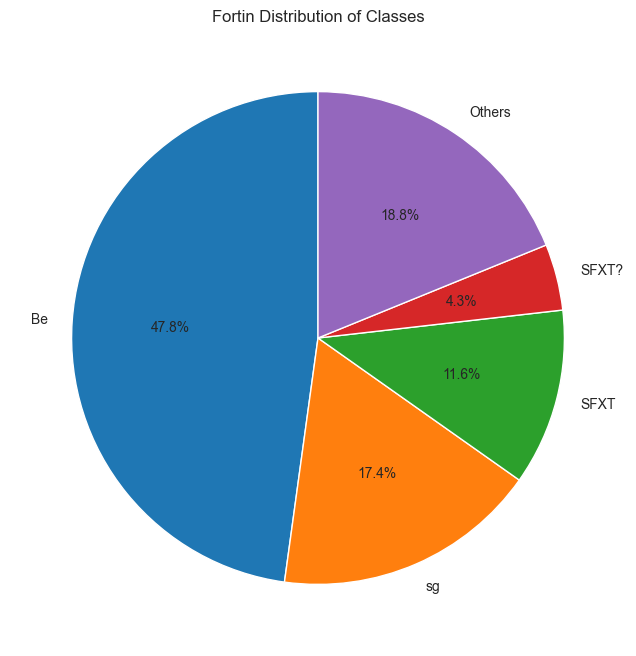

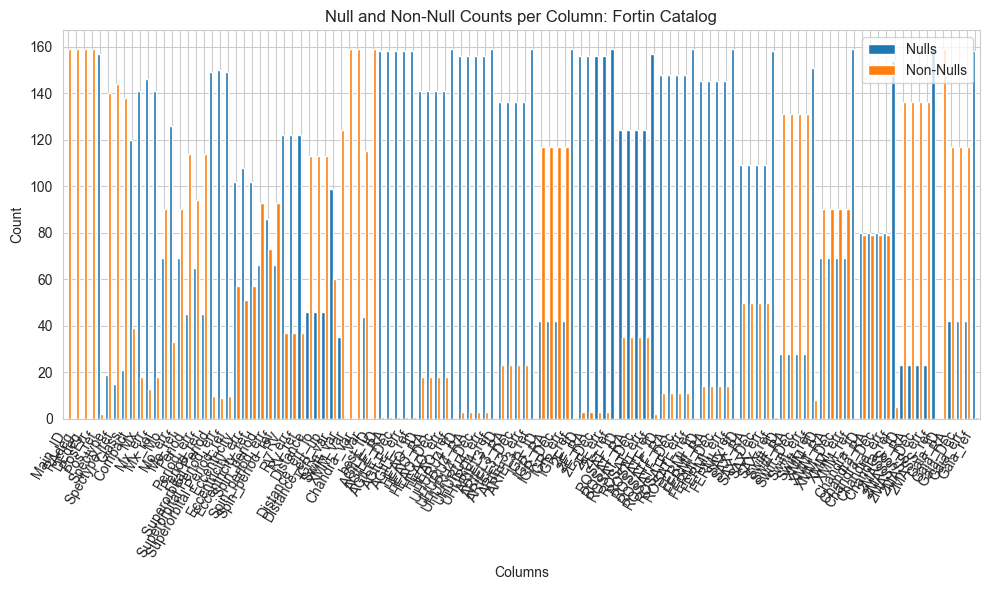

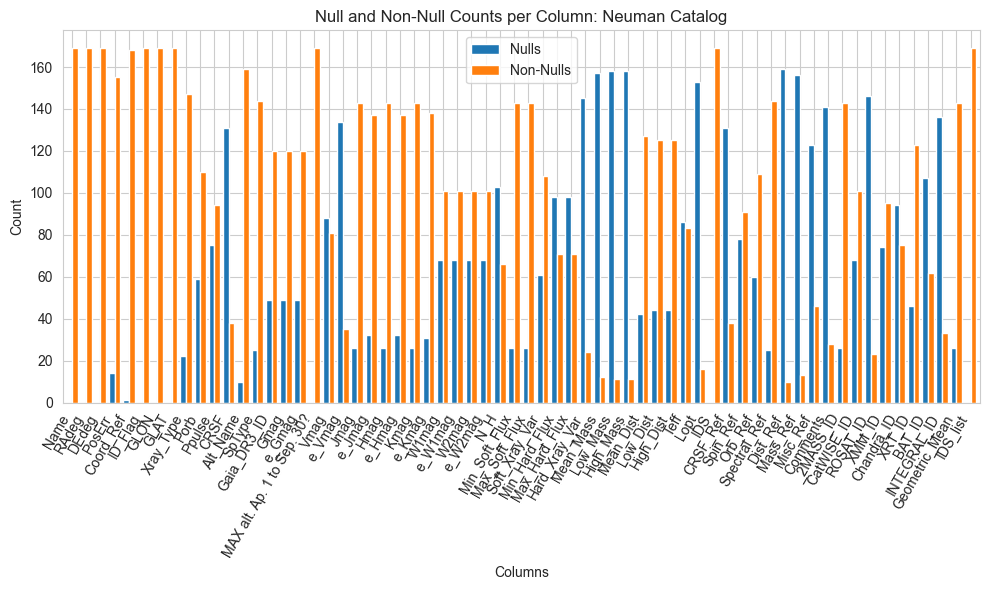

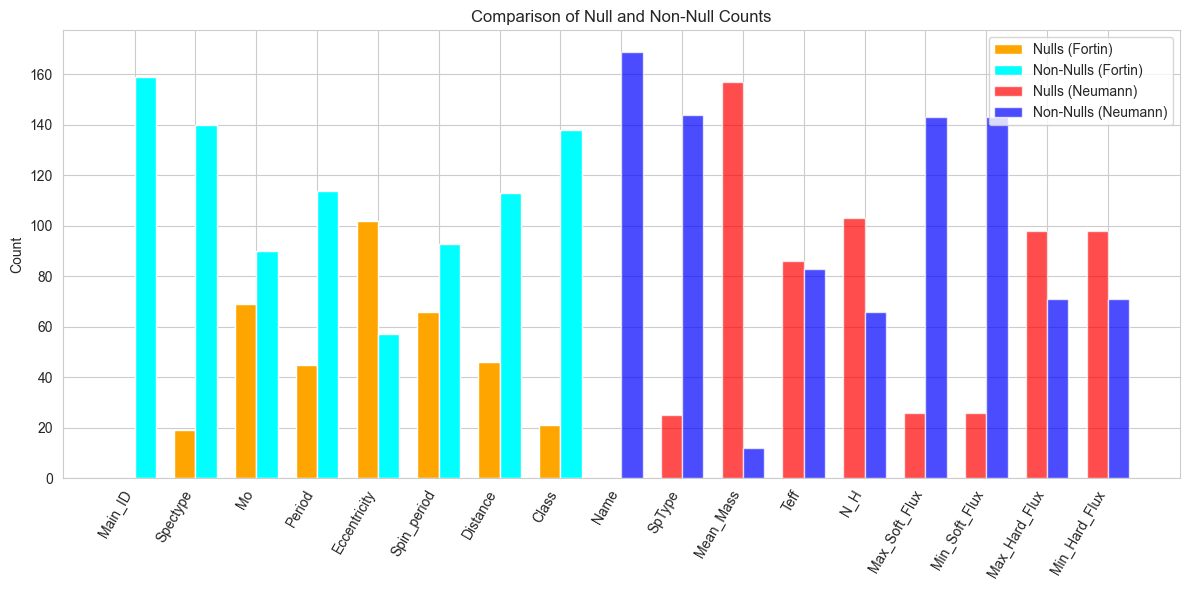

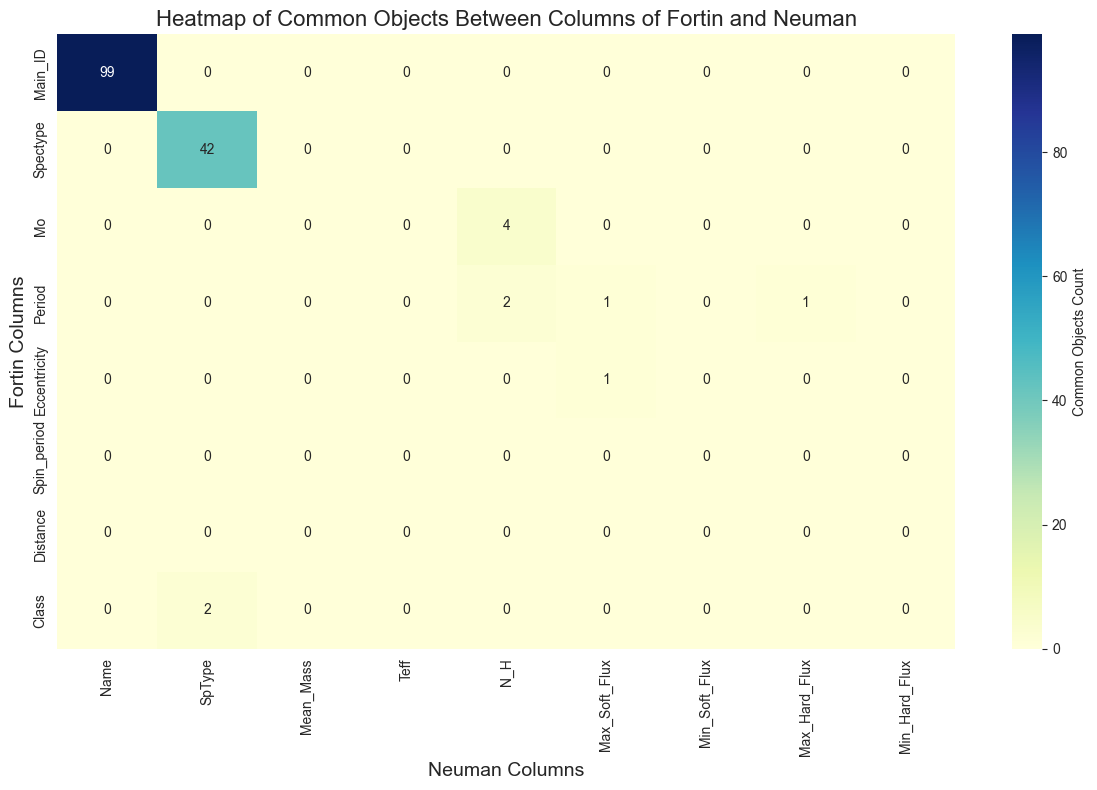

In [202]:

hmxb = HMXB("HMXB_catalogs.xlsx")
hmxb.load_catalogs()
hmxb.Compare_Neumann_Fortin()
final_dataframe = hmxb.Build_Final_Dataframe()
final_dataframe['SpType_Fortin']




hmxb.Compare_Neumann_Fortin()


final_dataframe = hmxb.Build_Final_Dataframe()

hmxb.plot_class_distribution()

hmxb.plot_null_histogram(hmxb.cat_fortin, 'Fortin Catalog')
hmxb.plot_null_histogram(hmxb.cat_neuman, 'Neuman Catalog')

columns_fortin = ['Main_ID', 'Spectype', 'Mo', 'Period', 'Eccentricity', 'Spin_period', 'Distance', 'Class']
columns_neuman = ['Name', 'SpType', 'Mean_Mass', 'Teff', 'N_H', 'Max_Soft_Flux', 'Min_Soft_Flux', 'Max_Hard_Flux', 'Min_Hard_Flux']
hmxb.compare_null_counts(columns_fortin, columns_neuman)

hmxb.plot_common_object_heatmap(columns_fortin, columns_neuman)




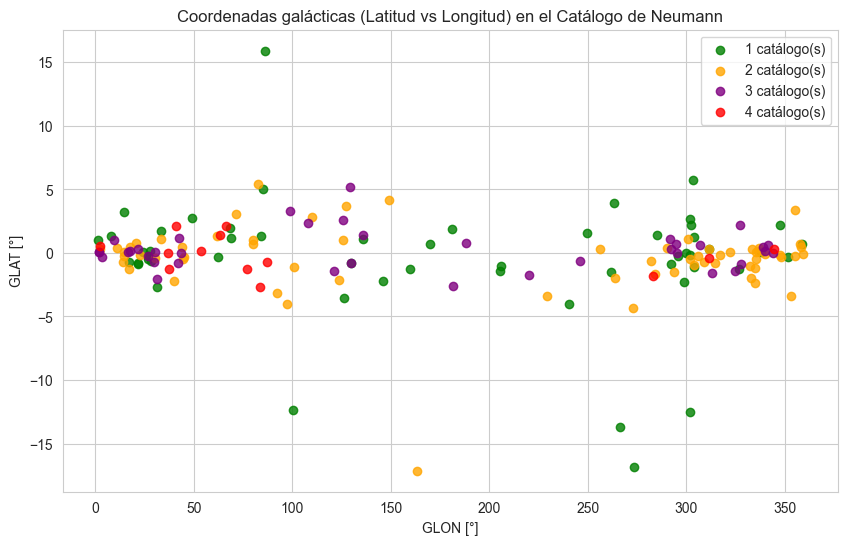

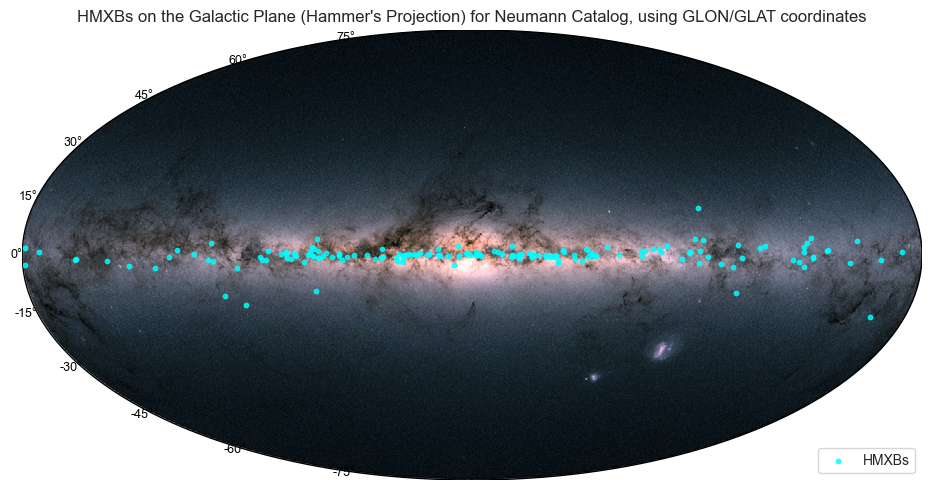

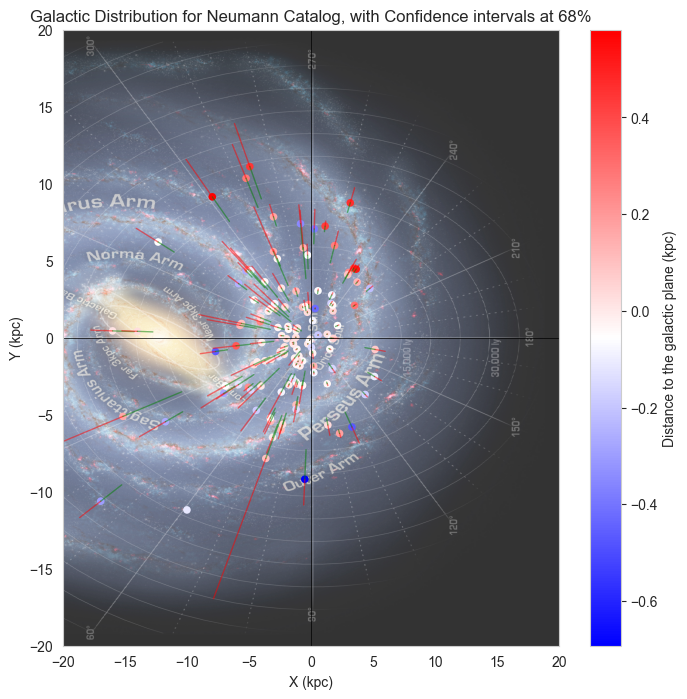

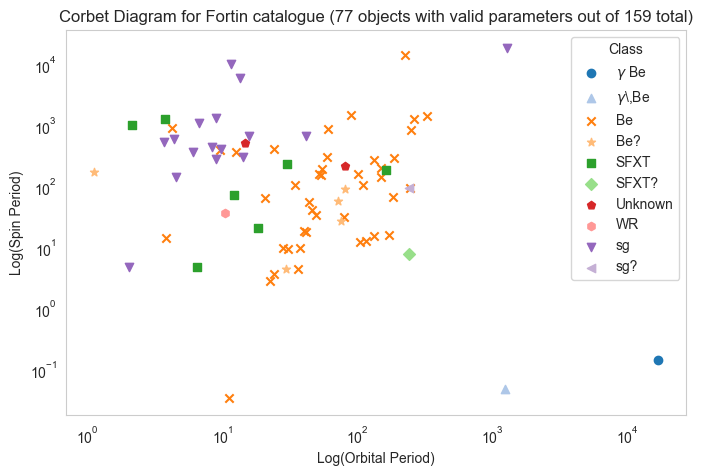

Total original data points: 169
Total valid data points (filtered and without NaN): 143


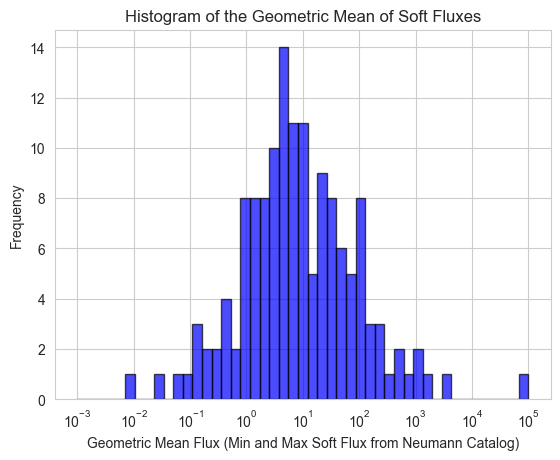

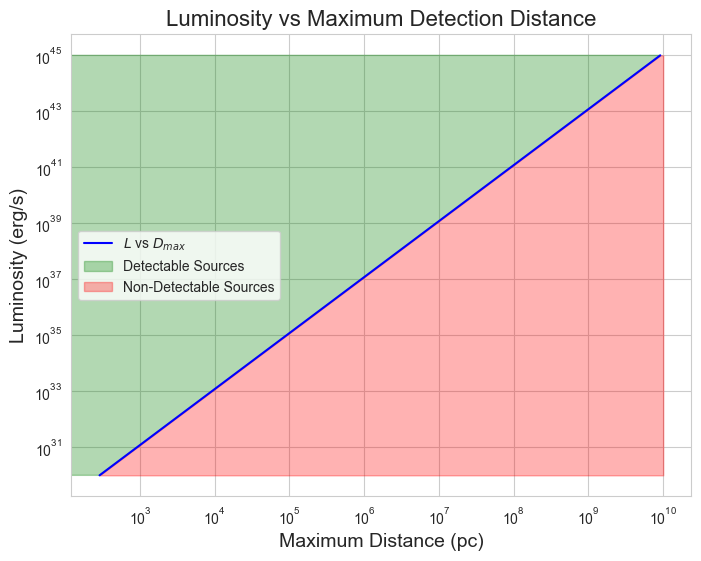

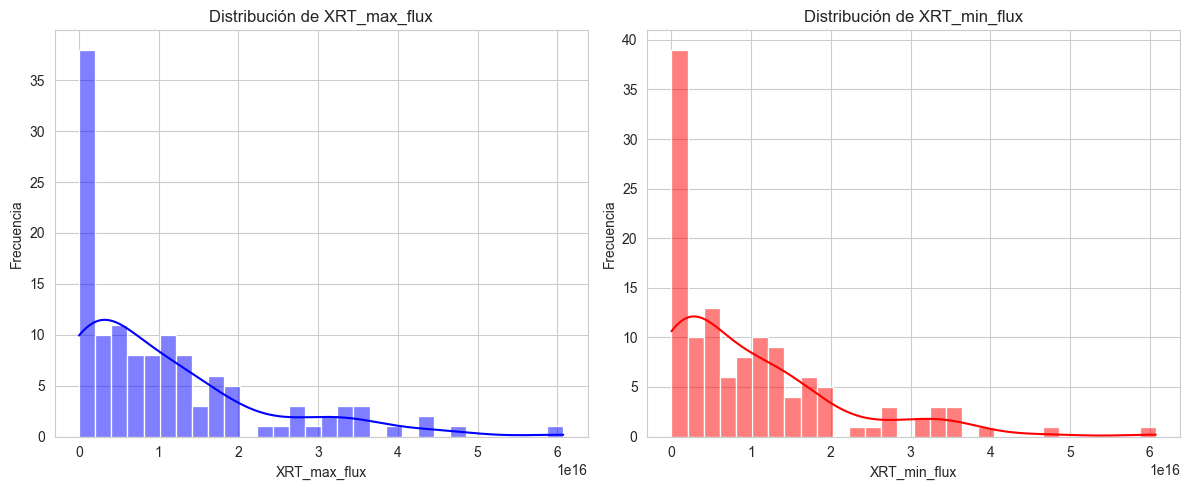

Total original data points: 172
Total valid data points (filtered and without NaN): 106


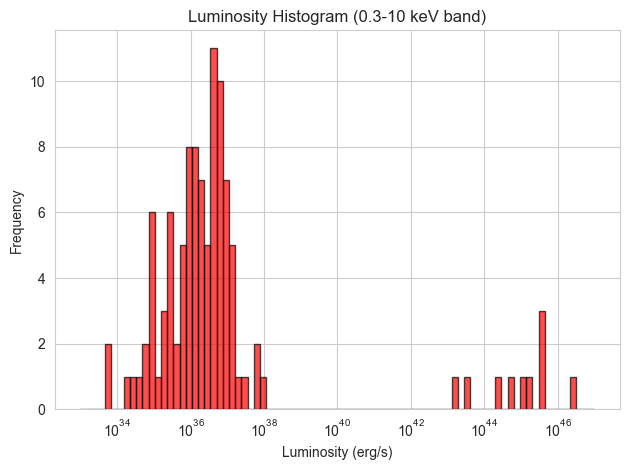

interactive(children=(Dropdown(description='X axis:', options=('Title: Catalog of the Galactic population of X…

Error in interactive setup: cannot find widget or abbreviation for argument: 'selected_columns_nan'


interactive(children=(Select(description='Class:', options=('sg', 'Be', '$\\gamma$\\,Be', 'sgB[e]', 'SFXT', 'S…

In [203]:


hmxb.plot_coordinate_groups()
hmxb.hammer_proyection_neumann()
hmxb.plot_galactic_distribution()
hmxb.Corbet_Diagram_plot()


hmxb.flux_histogram_plot()
hmxb.plot_luminosity_vs_max_distance()
hmxb.plot_flux_distributions()
hmxb.plot_log_histogram_luminosity(bins_per_decade=6, color='red')




# hmxb.plot_interactive_scatter()  #self.cat_fortin por defecto
hmxb.plot_interactive_scatter(hmxb.kim_persistent)


hmxb.interactive_analysis()



hmxb.interactive_kendall()
